In [52]:
!nvidia-smi

Wed Feb 11 23:39:38 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.86                 Driver Version: 591.86         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8              2W /  105W |    4496MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation
from pathlib import Path
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.data import experimental
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [54]:
training_set = image_dataset_from_directory(
    'train',
    image_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5702 files belonging to 3 classes.


In [55]:
validation_and_test_set = image_dataset_from_directory(
    'valid',
    image_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    class_names=None,
    shuffle=True,
    seed = 123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 1426 files belonging to 3 classes.


In [56]:
class_names = training_set.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


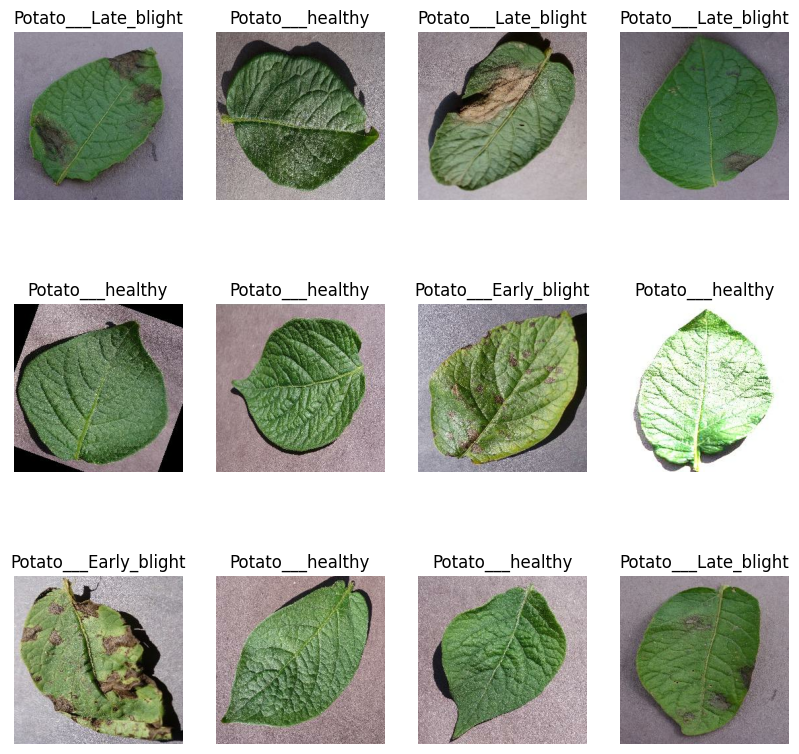

In [57]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in training_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [58]:
def get_dataset_partitions_tf(dataset, val_split=0.5, test_split=0.5, shuffle=True, shuffle_size=10000):

    assert (test_split + val_split) == 1
    
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    val_size = int(val_split * ds_size)
    
    val_ds = dataset.take(val_size)    
    test_ds = dataset.skip(val_size)
    
    return val_ds, test_ds

In [59]:
validation_set, test_set = get_dataset_partitions_tf(validation_and_test_set)

In [60]:
print(training_set)
print(validation_set)
print(test_set)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [61]:
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = Sequential([
    Rescaling(1./255),
    Resizing(256, 256)  
])

In [63]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [64]:
training_set = training_set.map(lambda x, y: (data_augmentation(x, training=True), y))  

In [65]:
num_classes = len(class_names)

model = Sequential([
    resize_and_rescale,

    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    Flatten(),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

In [66]:
model.build(input_shape=(None, 256, 256, 3))

In [67]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 64)      

In [68]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [69]:
training_history = model.fit(training_set, batch_size=32, validation_data=validation_set, verbose=1, epochs=30, callbacks=[early_stop])

Epoch 1/30
179/179 [==============================] - 34s 137ms/step - loss: 0.8690 - accuracy: 0.5572 - val_loss: 0.6050 - val_accuracy: 0.7391
Epoch 2/30
179/179 [==============================] - 21s 118ms/step - loss: 0.4293 - accuracy: 0.8339 - val_loss: 0.5345 - val_accuracy: 0.8087
Epoch 3/30
179/179 [==============================] - 21s 117ms/step - loss: 0.1735 - accuracy: 0.9363 - val_loss: 0.2815 - val_accuracy: 0.8957
Epoch 4/30
179/179 [==============================] - 22s 121ms/step - loss: 0.1277 - accuracy: 0.9526 - val_loss: 0.2717 - val_accuracy: 0.8942
Epoch 5/30
179/179 [==============================] - 22s 122ms/step - loss: 0.0870 - accuracy: 0.9691 - val_loss: 0.4659 - val_accuracy: 0.8551
Epoch 6/30
179/179 [==============================] - 22s 121ms/step - loss: 0.0905 - accuracy: 0.9656 - val_loss: 0.1435 - val_accuracy: 0.9551
Epoch 7/30
179/179 [==============================] - 22s 121ms/step - loss: 0.0616 - accuracy: 0.9776 - val_loss: 0.5956 - val_ac

In [70]:
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [80]:
model.save_weights('Potato_model_weights.h5')
model.save('Potato_model.h5')

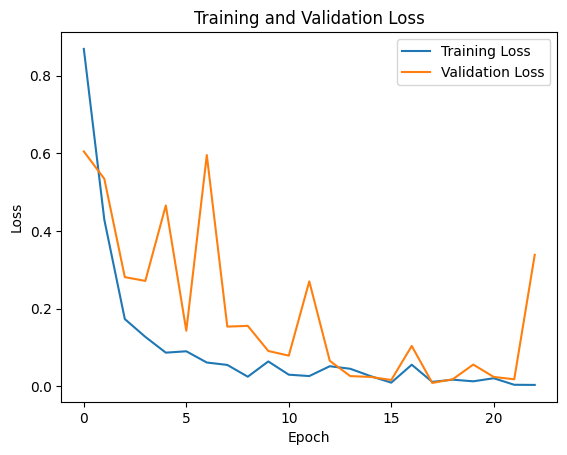

In [72]:
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

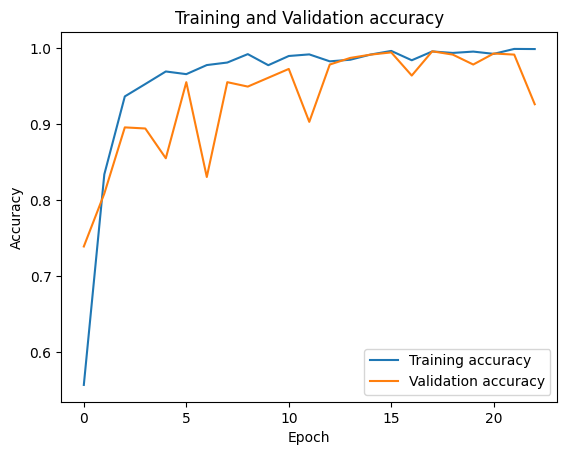

In [73]:
plt.plot(training_history.history['accuracy'], label='Training accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [74]:
training_history.history

{'loss': [0.8689547777175903,
  0.42925459146499634,
  0.1734667271375656,
  0.12765266001224518,
  0.08697126060724258,
  0.09049981087446213,
  0.061580732464790344,
  0.055391281843185425,
  0.025048401206731796,
  0.06433799862861633,
  0.030243877321481705,
  0.026712650433182716,
  0.05203493684530258,
  0.045462772250175476,
  0.026366066187620163,
  0.00975490640848875,
  0.05590350553393364,
  0.011720857582986355,
  0.01739848032593727,
  0.013188851065933704,
  0.021115001291036606,
  0.004264622461050749,
  0.0038976401556283236],
 'accuracy': [0.5571728944778442,
  0.8339179158210754,
  0.9363381266593933,
  0.9526482224464417,
  0.9691336154937744,
  0.9656261205673218,
  0.9775517582893372,
  0.9808838963508606,
  0.9919326305389404,
  0.9773763418197632,
  0.9894773960113525,
  0.991581916809082,
  0.9824622869491577,
  0.9845668077468872,
  0.9914065003395081,
  0.9961417317390442,
  0.9838653206825256,
  0.9954401850700378,
  0.9935110211372375,
  0.9952648282051086,


23/23 [==============================] - 2s 33ms/step


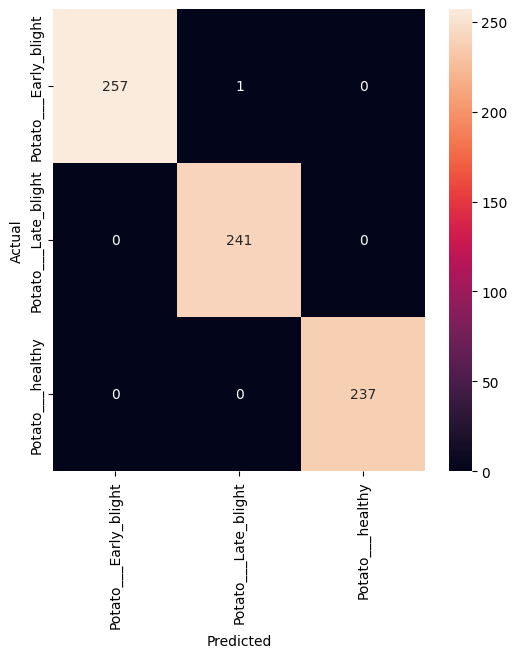

In [75]:
pred_probs = model.predict(test_set)
Y_pred = np.argmax(pred_probs, axis=1)

Y_true = tf.concat([y for x, y in test_set], axis=0).numpy()

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [76]:
print(classification_report(Y_true, Y_pred, target_names=class_names))

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       258
 Potato___Late_blight       1.00      1.00      1.00       241
     Potato___healthy       1.00      1.00      1.00       237

             accuracy                           1.00       736
            macro avg       1.00      1.00      1.00       736
         weighted avg       1.00      1.00      1.00       736



first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 98ms/step
predicted label: Potato___Early_blight


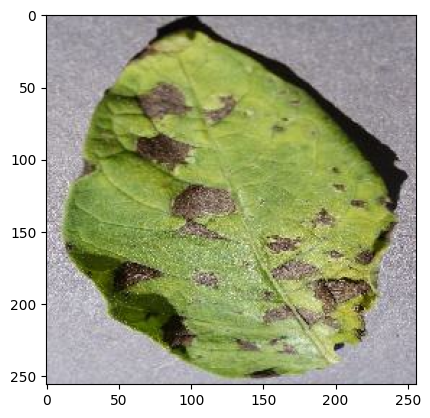

In [77]:
import numpy as np
for images_batch, labels_batch in test_set.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


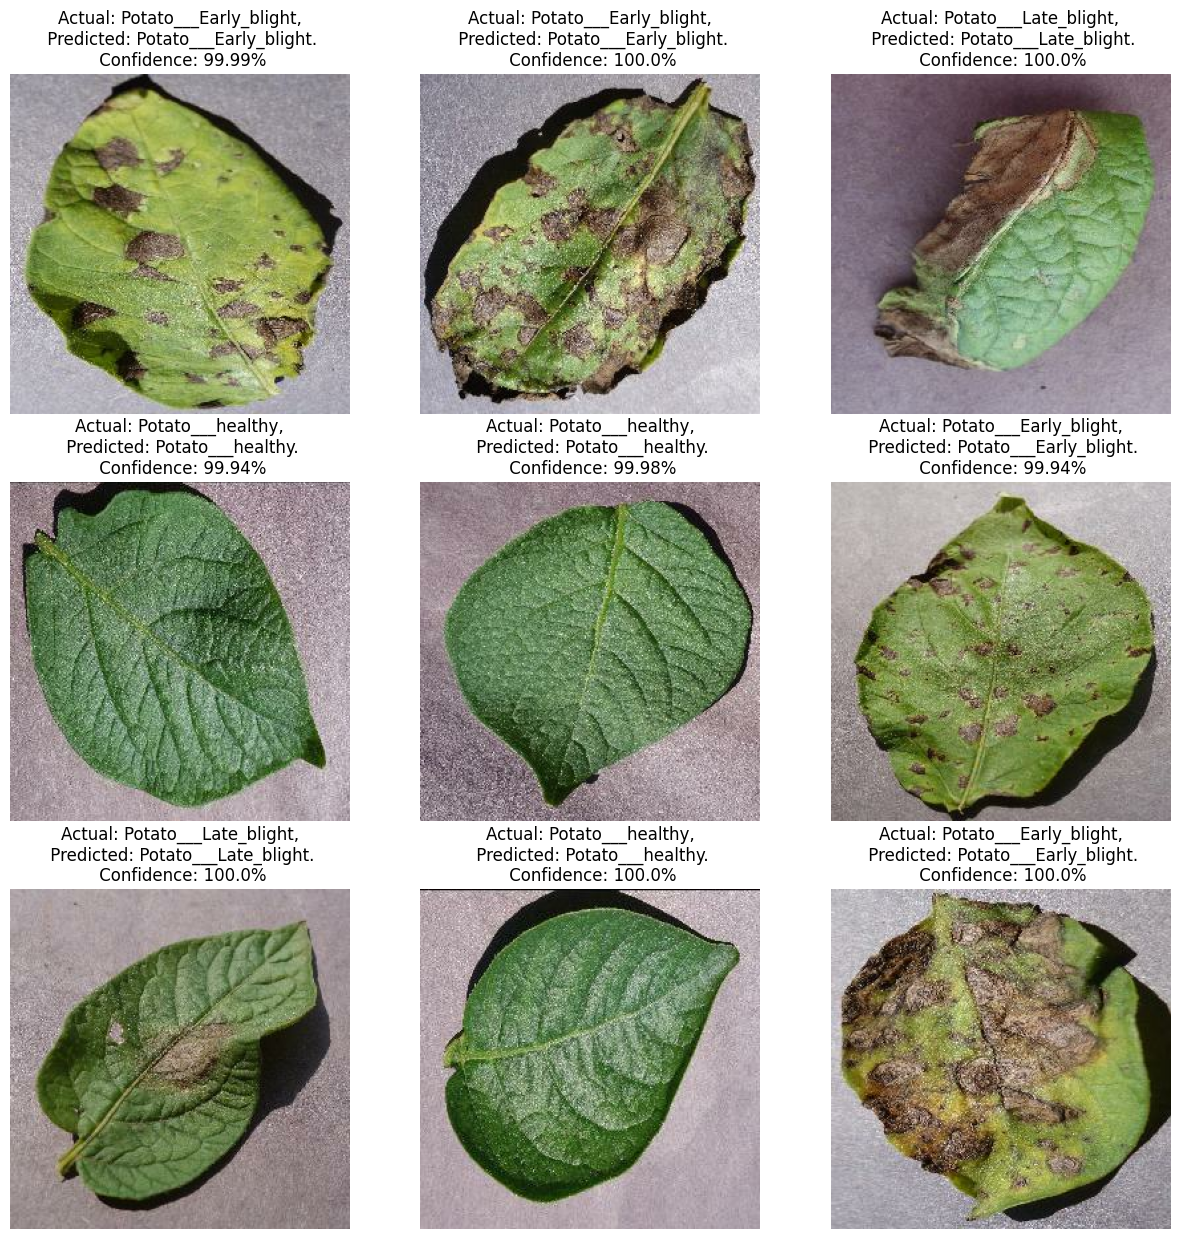

In [79]:
plt.figure(figsize=(15, 15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")